In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display

## Exercise 

This is a very long and complex exercise, that should give you an idea of a real world scenario. Feel free to look at the solution if you feel lost. Also, feel free to run this on Floyd with a GPU, in which case you don't need to download the data.

If you are running this locally, download and unpack the male/female pictures from [here](https://www.dropbox.com/s/nov493om2jmh2gp/male_female.tgz?dl=0). These images and labels were obtained from [Crowdflower](https://www.crowdflower.com/data-for-everyone/).

Your goal is to build an image classifier that will recognize the gender of a person from pictures.

- Have a look at the directory structure and inspect a couple of pictures
- Design a model that will take a color image of size 64x64 as input and return a binary output (female=0/male=1)
- Feel free to introduce any regularization technique in your model (Dropout, Batch Normalization, Weight Regularization)
- Compile your model with an optimizer of your choice
- Using `ImageDataGenerator`, define a train generator that will augment your images with some geometric transformations. Feel free to choose the parameters that make sense to you.
- Define also a test generator, whose only purpose is to rescale the pixels by 1./255
- use the function `flow_from_directory` to generate batches from the train and test folders. Make sure you set the `target_size` to 64x64.
- Use the `model.fit_generator` function to fit the model on the batches generated from the ImageDataGenerator. Since you are streaming and augmenting the data in real time you will have to decide how many batches make an epoch and how many epochs you want to run
- Train your model (you should get to at least 85% accuracy)
- Once you are satisfied with your training, check a few of the misclassified pictures. Are those sensible errors?

#### Download data

In [2]:
# if you are running this on floydhub.com, execute this cell and skip the next
data_path = '/input'

In [3]:
# If you are running this locally

# !mkdir -p ./data
# !wget https://www.dropbox.com/s/nov493om2jmh2gp/male_female.tgz?dl=0 -O ./data/male_female.tgz > /tmp/temp.outerr 2>&1
# !tar -xzvf ./data/male_female.tgz > /tmp/temp.outerr 2>&1
# !rm ./data/male_female.tgz

# data_path = './data'

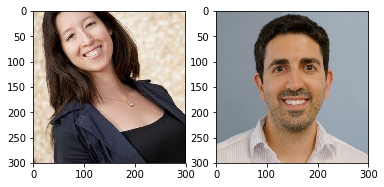

In [4]:
from PIL import Image

orignal_data_female = Image.open(data_path + '/train/0_female/153546-large.jpg')
orignal_data_male = Image.open(data_path + '/train/1_male/3642-large.jpg')

plt.subplot(1,2,1)
plt.imshow(orignal_data_female)
plt.subplot(1,2,2)
plt.imshow(orignal_data_male)

#### Augment Data

In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale = 1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rotation_range = 10,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               horizontal_flip = True)

test_gen = ImageDataGenerator(rescale = 1./255)

Using TensorFlow backend.


In [6]:
train = train_gen.flow_from_directory(data_path + '/train',
                                      target_size = (64, 64),
                                      batch_size = 16,
                                      class_mode = 'binary')

test = test_gen.flow_from_directory(data_path + '/test',
                                    target_size = (64, 64),
                                    batch_size = 16,
                                    class_mode = 'binary')

Found 11663 images belonging to 2 classes.
Found 2920 images belonging to 2 classes.


In [7]:
img, label = train.next()
print(img.shape)
print(label.shape)

(16, 64, 64, 3)
(16,)


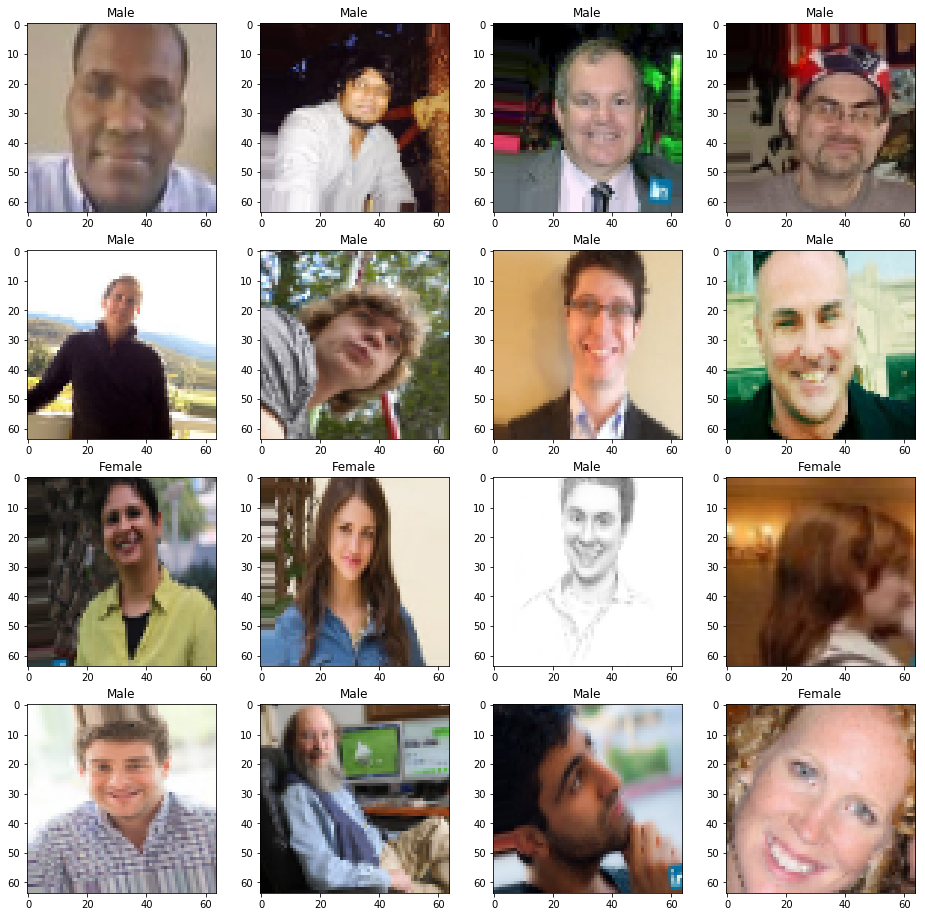

In [8]:
plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(img[i])
    plt.gca().set_title('{}'.format('Male' if int(label[i])==1 else 'Female'))

#### Model

In [9]:
from keras.layers import \
    Conv2D, \
    MaxPooling2D, \
    Flatten, \
    BatchNormalization, \
    Dense
from keras.models import Sequential
import keras.backend as K

K.clear_session()

model = Sequential()

# Feature Extraction layers
model.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(BatchNormalization())

# Flatten layer
model.add(Flatten())

# Fully connected layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

# Compile
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 31, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        36928     
__________

#### Train

In [10]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1)

!mkdir -p ./weights
checkpoint = ModelCheckpoint('./weights/male_female_weights.h5', save_best_only=True)

In [11]:
history = model.fit_generator(
    train,
    steps_per_epoch=800,
    epochs=200,
    validation_data=test,
    validation_steps=200,
    callbacks=[early_stop, checkpoint])

Epoch 1/200
800/800 [==============================] - 220s 276ms/step - loss: 0.6628 - acc: 0.6742 - val_loss: 0.5187 - val_acc: 0.7353
Epoch 2/200
800/800 [==============================] - 221s 276ms/step - loss: 0.4957 - acc: 0.7510 - val_loss: 0.4644 - val_acc: 0.7726
Epoch 3/200
800/800 [==============================] - 220s 275ms/step - loss: 0.4549 - acc: 0.7756 - val_loss: 0.4721 - val_acc: 0.7597
Epoch 4/200
800/800 [==============================] - 221s 276ms/step - loss: 0.4325 - acc: 0.7932 - val_loss: 0.4373 - val_acc: 0.7929
Epoch 5/200
800/800 [==============================] - 220s 275ms/step - loss: 0.4069 - acc: 0.8063 - val_loss: 0.4023 - val_acc: 0.8086
Epoch 6/200
800/800 [==============================] - 220s 275ms/step - loss: 0.3871 - acc: 0.8172 - val_loss: 0.4074 - val_acc: 0.8095
Epoch 7/200
800/800 [==============================] - 221s 276ms/step - loss: 0.3773 - acc: 0.8214 - val_loss: 0.4218 - val_acc: 0.7851
Epoch 8/200
800/800 [====================

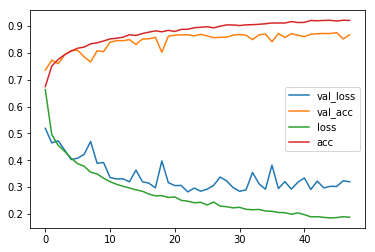

In [12]:
historydf = pd.DataFrame(history.history, index=history.epoch)
historydf.plot();

#### Evaluate

In [13]:
from keras.models import load_model

model = load_model('./weights/male_female_weights.h5')

In [14]:
from itertools import islice

X_test = []
y_test = []
for ts in islice(test, 50):
    X_test.append(ts[0])
    y_test.append(ts[1])

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

In [15]:
y_pred = model.predict_classes(X_test).ravel()

In [16]:
print('Accuracy: {} %'.format(
    float(len(np.argwhere(y_test==y_pred).ravel()))*100.0 / len(y_test)))

Accuracy: 85.75 %


#### Sample

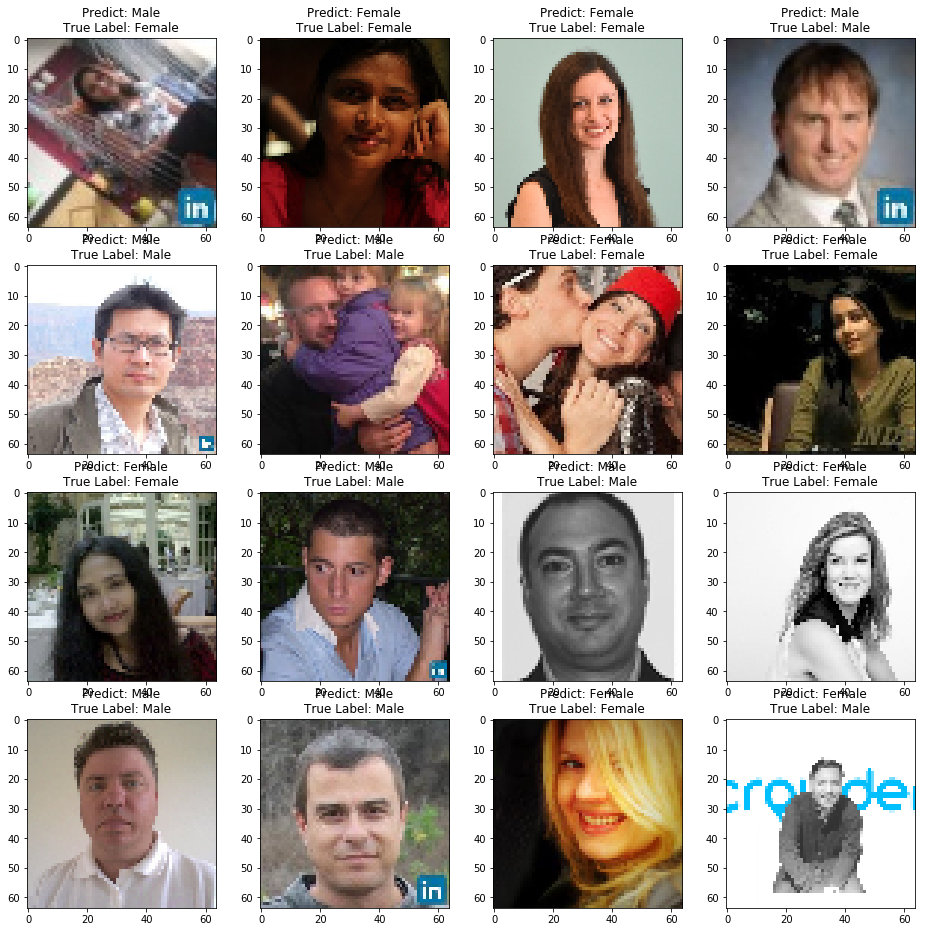

In [17]:
img, label = test.next()
pred = model.predict_classes(img).ravel()

plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(img[i])
    plt.gca().set_title(
        '''Predict: {}\nTrue Label: {}'''.format(
            'Male' if int(pred[i])==1 else 'Female',
            'Male' if int(label[i])==1 else 'Female'))